In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit


On s'intéresse à approximer la solution de l'équation de transport suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0 \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [42]:
#La Solution Iniciale:
@njit
def u0(x):
    if  x>=0.1 and x <= 0.2:
        return 10.
    else: return 0.

# Le flux Exacte:
@njit
def F(u,a):
    return a*u

# Les Flux des schemas:
@njit
def Rusanov(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a))-a*(ud-ug)

@njit
def Rusanov2(ug,ud,a,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-a*(ud-ug))

@njit
def Roe(ug,ud,a,dx,dt):
    if a >= 0:
        return F(ug,a)
    else:
        return F(ud,a)
    
@njit
def LF(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dx/(dt))*(ud-ug))
       
@njit
def LFM(ug,ud, a ,dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-0.5*(dx/(dt))*(ud-ug))
       
    
@njit
def LW(ug,ud, a, dx,dt):
    return 0.5*(F(ug,a)+F(ud,a)-(dt/dx)*(a**2)*(ud-ug))


@njit
def VFD(ug,ud, a, dx,dt):
    return F(ug,a)

@njit
def departure(dt, alpha, X, a):
    aux = 1.0
    eps = 1e-9

    x0 = 0.5 * (X[:-1] + X[1:])
    xmp = x0
    kit = 0

    while aux > eps:
        x1 = xmp - dt * alpha * a
        aux = np.max(np.abs(x1 - x0))

        x0 = x1
        kit += 1

    return x0, kit
@njit
def FvcFlux(N, X, alpha, dt, u, a):
    F = np.zeros(N - 1)
    up = np.zeros(N - 1)
    
    # Characteristics foot
    x0, _ = departure(dt, alpha, X, a)

    # Interpolation procedure
    ui = np.interp(x0, X, u)

    # Predictor stage
    for i in range(N - 1):
        up[i] = ui[i]

    # Corrector stage
    for i in range(N - 1):
        F[i] = a * up[i]

    return F

      
 
@njit
def VFC(U0, T,  N, alpha ,CFL , dx):
    
    Dt  = CFL*(dx/(2*a*alpha))
    
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    temps = 0
    
    while temps < T:
        temps += min(Dt,T-Dt)
        for i in range(1,N-1):
            X1 = X[i-1:i+2]
            u  = Un[i-1:i+2]
            F  = FvcFlux(3, X1, alpha, Dt, u, a)
            Fg = F[0]
            Fd = F[1]
            Unp1[i]=Un[i]-Dt/dx*(Fd-Fg)


        Unp1[0] = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]
        Un = Unp1.copy()
    return Un

@njit
def LinearAdvectionSolver(U0, T, l, L, a, N, CFL, dt, dx, scheme):
    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LF
    elif scheme == 4:
        flux = LFM
    elif scheme == 5:
        flux = LW
    elif scheme == 6:
        flux = VFD
    
    
    Un = U0.copy()
    Unp1 = np.zeros(N)
    temps = 0
    while temps < T:
        for i in range(1,N-1):
            Fd=flux(Un[i],Un[i+1], a, dx, dt)
            Fg=flux(Un[i-1],Un[i], a, dx, dt)
            Unp1[i]=Un[i]-dt/dx*(Fd-Fg)

        Unp1[0] = 0#Unp1[1]
        Unp1[N-1] = 0#Unp1[N-2]


        Un = Unp1.copy()
        temps += min(dt,T-dt)

    return Un

  
######################################################################################
T     =  1/4
l     =  0
L     =  1
a     =  2
N     =  101
CFL   =  1/2
alpha =  1/2
X     =  np.linspace(l,L,N)
dx    =  (L-l)/(N-1)
dt    =  CFL*dx/a
U0    =  np.array([u0(x) for x in X])




fluxes = {("Roe",0):1, ("Rusanov",1):1, ("Rusanov2",2):1, ("LF",3):1, ("LFM",4):1, ("LW",5):1, ("VFD",6):1}

f={}
for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  LinearAdvectionSolver  (U0, T, l, L, a, N, CFL, dt, dx, i[1])   
    
U_VFC = VFC(U0, T,  N, alpha ,CFL , dx)

UExact=np.array([u0(x-T*a) for x in X])


/tmp/ipykernel_50040/1129624264.py:134: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


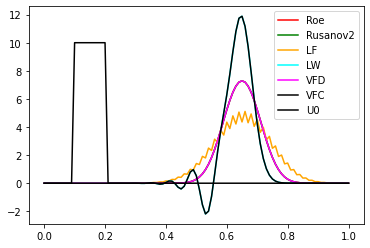

In [43]:
PLOT = {"Roe":1, "Rusanov":0, "Rusanov2":1, "LF":1, "LFM":0, "LW":1, "VFD":1 }

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    
plt.plot(X, U_VFC, '-k',  label='VFC')
plt.plot(X, U0, '-k',  label='U0')

#plt.xlim([0.4, 0.6])  
#plt.ylim([-0.5, 11])  

plt.legend()
plt.pause(0.1)


In [36]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm

{'Roe': 33.166247903554,
 'Rusanov': 1.3588688656248594e+24,
 'Rusanov2': 33.166247903554,
 'LF': 33.166247903554,
 'LFM': 4995.883189668576,
 'LW': 33.166247903554,
 'VFD': 33.166247903554}